In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

#### RANSAC (Random Sample Consensus) Algorithm steps:

1) Sample `s` points from the data
2) Compute model parameters
3) Count number of inliers, i.e. how many points from the dataset fit the model (upto a threshold)
4) Repeat until we find model with largest inlier ratio (number of iterations need to be set appropriately to maximize the probability of finding this best model)

#### Lets use RANSAC to fit a linear model to 2d data

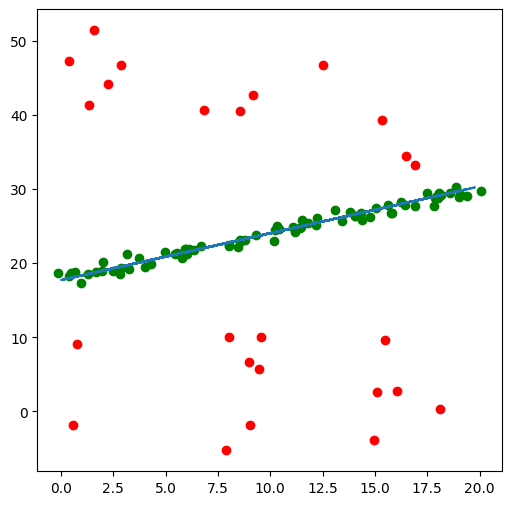

In [30]:
nsamples = 100
outlier_ratio = 0.25

np.random.seed(1)

# first, generate some sample data
x = 20*np.random.random(size=(nsamples))

# generate a random slope and intercept for the line
m = 2.0*np.random.normal()
c = 20*np.random.random()

y = m * x  + c

# now add some gaussian random noise to the data
x_noisy = x + 0.5*np.random.normal(size=x.shape)
y_noisy = y + 0.5*np.random.normal(size=y.shape)

# now add some outliers (i.e. randomly select a subset of points, and replace them with outlier points)
n_outliers = int(nsamples * outlier_ratio)
indices = np.arange(nsamples)
np.random.shuffle(indices)
outlier_indices = indices[0:n_outliers]
inlier_indices =  indices[n_outliers:]

x_noisy[outlier_indices] = 20*np.random.random(size=(n_outliers))
y_noisy[outlier_indices[0:int(n_outliers/2)]] +=  15 + 10*np.random.random(size=(int(n_outliers/2)))
y_noisy[outlier_indices[int(n_outliers/2):]] +=  -15 - 10*np.random.random(size=(n_outliers-int(n_outliers/2)))


# plot the data
plt.figure(figsize=(6,6))
plt.plot(x_noisy[inlier_indices], y_noisy[inlier_indices], marker='o', linestyle='None', color='green', )
plt.plot(x_noisy[outlier_indices], y_noisy[outlier_indices], marker='o', linestyle='None', color='red')
plt.plot(x,y, linestyle='-')
plt.show()



#### Now let's implement the RANSAC loop

In [64]:
# computes perpendicular distance from the line with (slope,intercept) = (m,c) to the point (x0,y0)
def perp_distance(m,c, x0, y0):
    d = np.abs(y0 - (m*x0 + c)) /np.sqrt(1 + m**2)     
    return d


def inlier_rat(data, model_params, threshold):
    # loop over every data point
    inlier_count = 0
    x_inliers = []
    y_inliers = []
    for i in range(len(data)):
        x, y = data[i,0], data[i,1] 
        # compute perpendicular distance from line
        d = perp_distance(model_params[0], model_params[1], x, y)
        # check if inlier (i.e. distance within threshold)
        if(d < threshold):
            inlier_count += 1
            x_inliers.append(x)
            y_inliers.append(y)

    ratio = inlier_count/len(data)
    
    return ratio, x_inliers, y_inliers

def plot_ransac(iteration, x, y, x_inliers, y_inliers, sample_points, model_params):
    
    plt.figure(figsize=(6,6))
    plt.plot(x, y, marker='o', linestyle='None', color='red', alpha=0.25, label='input data')
    plt.plot(x_inliers, y_inliers, marker='o', linestyle='None', color='green', alpha=0.85, label='inliers')
    x_sample = sample_points[:,0]
    y_sample = sample_points[:,1]
    y_model = model_params[0] * x + model_params[1]
    plt.plot(x_sample,y_sample, marker='o', linestyle='None', alpha = 0.9, label='sampled points')
    plt.plot(x, y_model, linestyle='-', color='blue', linewidth=0.1, label='line model')
    plt.legend()
    plt.title('Iteration #' + str(iteration))
    plt.show()


def RANSAC(x, y, num_iters=1, threshold=2.0):

    data = np.array(list(zip(x,y)))
    best_ratio = 0.0
    best_model_params = None

    for i in range(num_iters):

        # select two points uniformly at random
        indices = np.arange(len(data))
        np.random.shuffle(indices)
        indices_sample = indices[:2]
        indices_other = indices[2:]
        sample = data[indices_sample]

        # compute model parameters
        slope = (sample[1,1] - sample[0,1])/ (sample[1,0] - sample[0,0])
        intercept = sample[1,1] - slope * sample[1,0]
        model_params = (slope, intercept)

        # compute inlier ratio (exlude the sample points)
        inlier_ratio, x_inliers, y_inliers = inlier_rat(data[indices_other], model_params, threshold) 

        # save best model
        if(inlier_ratio > best_ratio):
            best_ratio = inlier_ratio
            best_model_params = model_params
            print(f"Iteration# {i}, Found better inlier ratio: {best_ratio}, model_params: {best_model_params}")

            plot_ransac(i, x, y, x_inliers, y_inliers, sample, best_model_params)

            


Iteration# 1, Found better inlier ratio: 0.20408163265306123, model_params: (3.5413435632701296, -23.963383263565873)


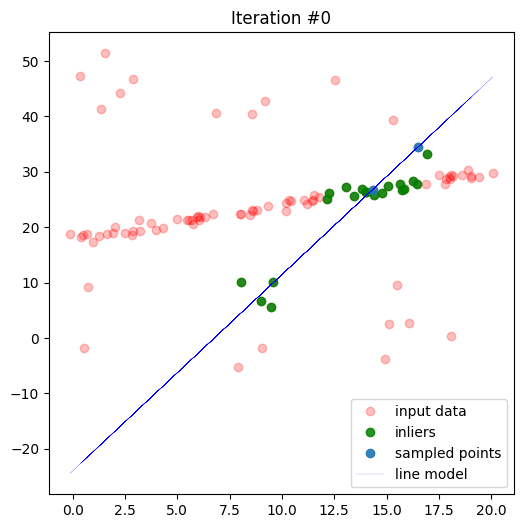

Iteration# 2, Found better inlier ratio: 0.2653061224489796, model_params: (1.5753904803805814, 14.827023390457253)


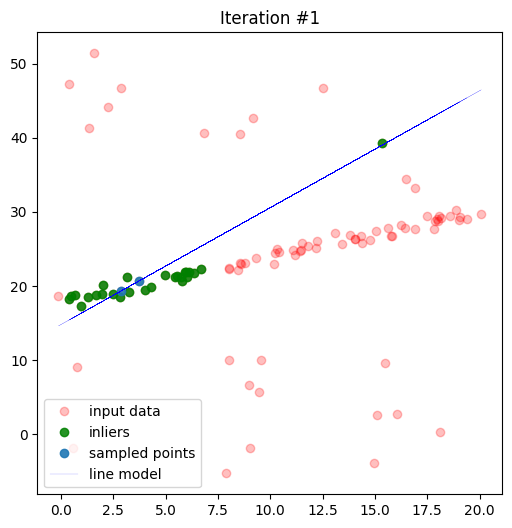

Iteration# 3, Found better inlier ratio: 0.7346938775510204, model_params: (0.7480236392085502, 16.334190643554436)


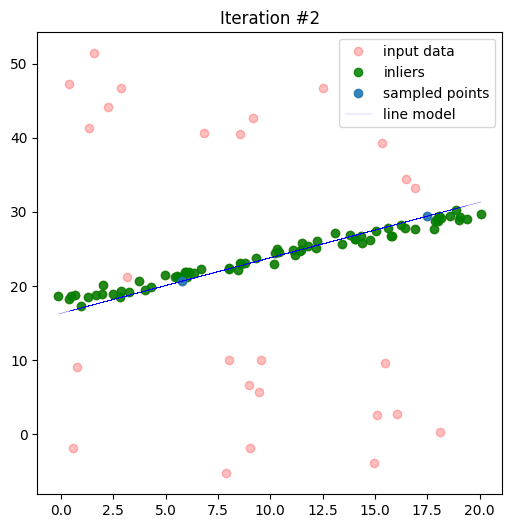

Iteration# 5, Found better inlier ratio: 0.7448979591836735, model_params: (0.607025289137585, 18.39398760130775)


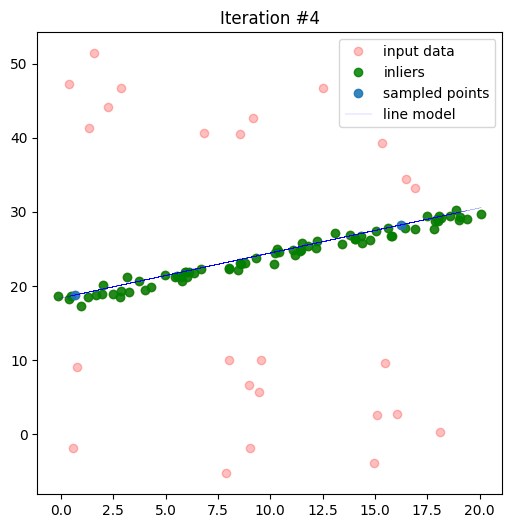

In [73]:
# estimated number of iterations needed to find pure inlier sample with 99% probability
Niters = 10*int(np.ceil(np.log(0.01)/ np.log(1-(1-outlier_ratio)**2))) 

RANSAC(x_noisy, y_noisy, Niters)